This notebook uses geographical data of risk factors + covid cases/deaths by county to generate predictions

In [1]:
#import ML libraries

import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load data
#in this case, generated by "Covid Geographical Analysis" notebook

#i did this on google colab, which is why the path is like this
DATA_FILE = '/content/county_deaths_risks.csv'

df = pd.read_csv(DATA_FILE)
df

,countyFIPS,population,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,Diabetes_Percentage,Diabetes_Lower Limit,Diabetes_ Upper Limit,Heart_Hospitalizations
0,0,0,Statewide Unallocated,AL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,Statewide Unallocated,AK,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Statewide Unallocated,AZ,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,Statewide Unallocated,AR,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Statewide Unallocated,CA,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,56037,42343,Sweetwater County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,8.0,6.6,9.9,0.0591
5690,56039,23464,Teton County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,2.2,1.3,3.2,0.0335
5691,56041,20226,Uinta County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000099,0.000099,0.000099,0.

In [3]:
#checking data, looks good

df.dtypes

countyFIPS                  int64
population                  int64
County Name                object
State                      object
stateFIPS                   int64
                           ...   
11/15/20                  float64
Diabetes_Percentage       float64
Diabetes_Lower Limit      float64
Diabetes_ Upper Limit     float64
Heart_Hospitalizations    float64
Length: 308, dtype: object

In [4]:
main_df = df.dropna()

main_df

,countyFIPS,population,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,Diabetes_Percentage,Diabetes_Lower Limit,Diabetes_ Upper Limit,Heart_Hospitalizations
2550,1001,55869,Autauga County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000519,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000573,0.000573,0.000644,0.000644,0.000644,11.4,8.3,15.2,0.0842
2551,1003,223234,Baldwin County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000291,0.000291,0.000291,0.000296,0.000296,0.000300,0.000300,0.000300,0.000300,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000318,0.000318,0.000318,0.000318,0.000331,0.000345,0.000345,0.000372,0.000372,0.000372,0.000372,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,8.2,6.9,9.7,0.0638
2552,1005,24686,Barbour County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,15.1,9.9,22.7,0.0749
2553,1007,22394,Bibb County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000536,0.000536,0.000536,0.000581,0.000581,0.000581,0.000581,0.000581,0.000581,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000714,0.000714,0.000714,0.000759,0.000759,0.000759,0.000759,0.000759,0.000759,12.2,7.8,18.5,0.0685
2554,1009,57826,Blount County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000277,0.000277,0.000277,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.000415,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000450,0.000450,0.000450,0.000450,0.000450,0.000588,0.000588,0.000588,0.000588,0.000588,12.2,8.9,16.6,0.0613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,56037,42343,Sweetwater County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000

In [5]:
#try to create a model that predicts deaths from risk factors

#Note to self: make sure features are normalized
#debatable -- should i include population? might mess with the risk factor analysis part

#first, define training data

features = ['Diabetes_Percentage','Heart_Hospitalizations']

y = main_df['11/15/20'] * 1e3 #covid death rate on this day, in rate per ____
#the 1e5 factor is so the model training is easier

X = main_df[features]
X['Heart_Hospitalizations'] *= 10
X['Diabetes_Percentage'] /= 100

X.join(y) #display data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Diabetes_Percentage,Heart_Hospitalizations,11/15/20
2550,0.114,0.842,0.644364
2551,0.082,0.638,0.376287
2552,0.151,0.749,0.364579
2553,0.122,0.685,0.759132
2554,0.122,0.613,0.587971
...,...,...,...
5689,0.080,0.591,0.094467
5690,0.022,0.335,0.085237
5691,0.095,0.529,0.148324
5692,0.082,0.354,0.896861


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

In [7]:
#define model -- just a dumb simple dense neural network

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

def make_model():
  model = tf.keras.Sequential([
      layers.Dense(50, activation = 'relu', input_shape = (2,)),
      layers.Dense(50, activation = 'relu'),
      layers.Dense(1)
  ])

  optimizer = Adam(learning_rate = 0.005)
  model.compile(optimizer = optimizer, loss = 'mse')
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


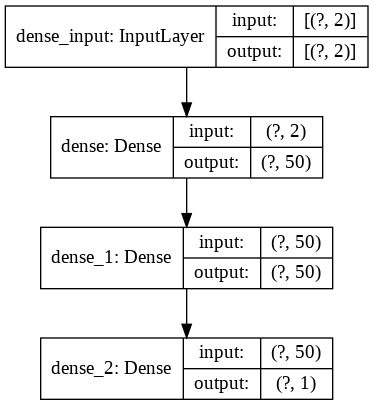

In [8]:
model = make_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True)

In [9]:
#now do training
#note to self: add validation data or cv
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [ReduceLROnPlateau()]

history = model.fit(X_train, y_train, validation_split = 0.2, batch_size = 100, epochs = 250, callbacks = callbacks)

Epoch 1/350
22/22 [==============================] - 0s 8ms/step - loss: 0.5575 - val_loss: 0.4068
Epoch 2/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4209 - val_loss: 0.4050
Epoch 3/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4165 - val_loss: 0.4035
Epoch 4/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4154 - val_loss: 0.4014
Epoch 5/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4150 - val_loss: 0.4107
Epoch 6/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4187 - val_loss: 0.4015
Epoch 7/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4114 - val_loss: 0.4014
Epoch 8/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4118 - val_loss: 0.4007
Epoch 9/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4115 - val_loss: 0.3977
Epoch 10/350
22/22 [==============================] - 0s 2ms/step - loss: 0.4099 - val_loss: 0.3975
Epoch 11/

In [10]:
history.history

{'loss': [0.5575040578842163,
  0.42089247703552246,
  0.4165286421775818,
  0.41542574763298035,
  0.4150327444076538,
  0.41869083046913147,
  0.41139769554138184,
  0.4117717146873474,
  0.411520779132843,
  0.409933865070343,
  0.4095909297466278,
  0.40801918506622314,
  0.40917882323265076,
  0.40879854559898376,
  0.4059244394302368,
  0.40536579489707947,
  0.4058343172073364,
  0.4067738354206085,
  0.4026716947555542,
  0.40346646308898926,
  0.40328094363212585,
  0.4031820595264435,
  0.40237027406692505,
  0.40176722407341003,
  0.41257891058921814,
  0.4060131013393402,
  0.4046012759208679,
  0.4150235652923584,
  0.4044997990131378,
  0.40080583095550537,
  0.40121883153915405,
  0.40038228034973145,
  0.40041667222976685,
  0.4012889266014099,
  0.40060552954673767,
  0.400362104177475,
  0.4000006914138794,
  0.40000811219215393,
  0.39982661604881287,
  0.39982903003692627,
  0.39982134103775024,
  0.3998217284679413,
  0.3998238444328308,
  0.3998028337955475,
  0.3

In [11]:
#check the root mean squared error of the predictions
#basically, lower is better


np.sqrt(model.evaluate(X_test,y_test))

15/15 [==============================] - 0s 1ms/step - loss: 0.4646


0.6816445161987116

In [15]:
#compare predictions to actual values

predictions = model.predict(X_test)
ser = pd.Series(predictions.ravel())
ser.index = X_test.index
ser.name = 'Predictions'

compare_df = X_test.join(y_test).join(ser)
compare_df['difference'] =  compare_df['Predictions'] - compare_df['11/15/20']
compare_df

,Diabetes_Percentage,Heart_Hospitalizations,11/15/20,Predictions,difference
4247,0.099,0.426,0.000000,0.565380,0.565380
4667,0.135,1.086,0.159333,0.919869,0.760536
3287,0.105,0.788,0.340473,0.720653,0.380180
4768,0.069,0.448,0.070817,0.491790,0.420972
3127,0.068,0.274,0.239995,0.389204,0.149209
...,...,...,...,...,...
3833,0.105,0.681,0.203600,0.676292,0.472693
2633,0.086,0.508,0.046161,0.557963,0.511802
3494,0.130,0.292,0.000000,0.613387,0.613387
4724,0.120,0.480,0.062486,0.667086,0.604600


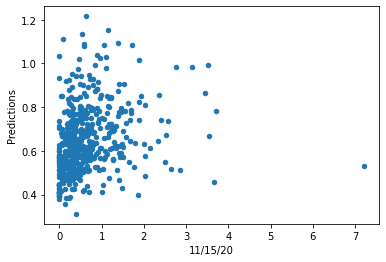

In [16]:
#plot actual value vs predictions
#ideally, this is a perfect straight line y=x

compare_df.plot(x = '11/15/20', y='Predictions', kind = 'scatter')

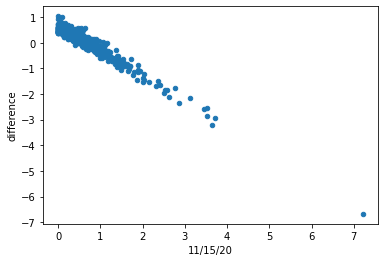

In [17]:
#plot actual value vs difference between the two
#ideally, this should be a flat line at 0, but clearly it's not

compare_df.plot(x='11/15/20', y='difference', kind='scatter')

From a quick glance, the model isn't looking too good right now



Text(0.5, 0, 'Prediction Error')

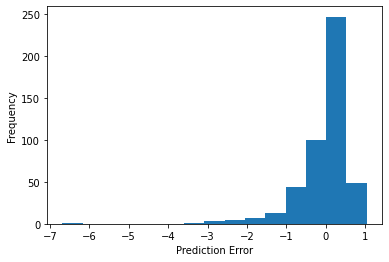

In [18]:
compare_df['difference'].plot(kind = 'hist', bins = 15)
plt.xlabel('Prediction Error')